<a href="https://colab.research.google.com/github/nokados/alternate/blob/main/Alternate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternate MVP

*Carpe diem. Memento mori*

Здесь должно быть описание что это такое, зачем все это и как этим пользоваться

TODO:
- Отрисовка квадратиков жизни
- Создание проектов (без подпроектов)
- Создание их стохастических функций времени (сумма синусоид, ШИМ со случайной длиной волны, ШИМ с затуханием, )
- 1 стратегия для комбинирования - колесо фортуны по приоритету
- Отрисовка финального графика, подсчет статистики для 1 симуляции
- В конце ноутбука обратная связь через Google Forms, мои контакты и донаты

## Сколько осталось жить?

Рисуем график с вероятностью остаться в живых в каждый следующий день. Вертикальной чертой на графике отмечена средняя дата смерти.

*Сейчас для простоты в качестве метода оценки смертности берется смертность в России в 2018, без разделения по полу. Данные из https://platform.who.int/mortality/themes/theme-details/MDB/all-causes
TODO: 1) полноценно проанализировать полный датасет, сделать более точную оценку с выборкой по стране и полу и другими параметрами. 2) сделать возможность варьировать личную оценку смертности*

In [2]:
# @title { run: "auto", display-mode: "form" }
# @markdown ### Введите пол:
# @markdown Построенный график показывает смертность по возрастам для выбранного
# @markdown пола.

# @markdown **Внимание:**  Эти вероятности очень условны и совсем не претендуют
# @markdown на истинность. Распределение выбрано методом пальцем в небо,
# @markdown а данные для подгонки сгенерированы искусственно. Не говоря уж о том,
# @markdown что они не учитывают ваш образ жизни и тренд на повышение
# @markdown продолжительности жизни. Подробнее -
# @markdown https://colab.research.google.com/drive/1mcxwcsrioNe4bygk2TYTfv8V-fYidhva?usp=sharing

# @markdown Так что можете подкрутить график, как вам нравится. Чтобы сбросить
# @markdown изменения выберите пол заново

# @markdown ---

from datetime import datetime, timedelta

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
from ipywidgets import interactive
from scipy.stats import weibull_min

sex = "Мужской" # @param ["Не выбран", "Мужской", "Женский"]


if sex == "Мужской":
    c = 4.133981693607855
    scale = 71.55956958252537
    bias = 2.600743376894613
elif sex == "Женский":
    c = 4.648590855539192
    scale = 83.5322317160395
    bias = 0.9647339058160895

death_distr = None

# Функция, которую будем отрисовывать
def plot_function(c, **kwargs):
    global death_distr
    x = np.linspace(0, 150, 400)
    death_distr = weibull_min(c, **kwargs)
    y = death_distr.pdf(x)

    mean_value = death_distr.mean()
    median_value = death_distr.median()
    quantile_25 = death_distr.ppf(0.25)
    quantile_75 = death_distr.ppf(0.75)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="Плотность смертности")

    # Добавляем среднее значение, медиану и квантили на график
    plt.axvline(
        mean_value, color='r', linestyle='--',
        label=f'Среднее: {mean_value:.2f}'
    )
    plt.axvline(
        median_value, color='g', linestyle='--',
        label=f'Медиана: {median_value:.2f}'
    )
    plt.axvline(
        quantile_25, color='b', linestyle='--',
        label=f'25% квантиль: {quantile_25:.2f}'
    )
    plt.axvline(
        quantile_75, color='b', linestyle='--',
        label=f'75% квантиль: {quantile_75:.2f}'
    )


    plt.xlabel('Возраст')
    plt.ylabel('Вероятность смерти')
    plt.title('Распределение смертности по возрасту')
    plt.legend()

    plt.grid(True)
    plt.show()

try:
    # Создаем интерактивные слайдеры для изменения параметров
    interactive_plot = interactive(
        plot_function,
        c=widgets.FloatSlider(value=c, min=1, max=20, step=0.1),
        loc=widgets.FloatSlider(value=bias, min=0, max=50, step=0.5),
        scale=widgets.FloatSlider(value=scale, min=0, max=300, step=0.5)
    )
except NameError:
    print("Необходимо выбрать пол, чтобы продолжить")
else:
    # Отображаем интерактивный график
    display(interactive_plot)

interactive(children=(FloatSlider(value=4.133981693607855, description='c', max=20.0, min=1.0), FloatSlider(va…

In [10]:
# @title { run: "auto", display-mode: "form" }
# @markdown ### Введите дату рождения:

birth_date = '1984-08-13' # @param {type:"date"}
birth_date = datetime.fromisoformat(birth_date)
current_date = datetime.now()


def calculate_age(birth_date, target_date):
    # Вычисляем возраст в годах
    age = target_date.year - birth_date.year

    # Проверяем, был ли день рождения в текущем году
    if (target_date.month, target_date.day) < (birth_date.month, birth_date.day):
        age -= 1

    last_digit = age % 10
    if last_digit == 1 and age != 11:
        age_str = "год"
    elif (
        last_digit > 1
        and last_digit < 5
        and (age < 10 or age > 15)
    ):
        age_str = "года"
    else:
        age_str = "лет"

    return age, age_str


age, age_str = calculate_age(birth_date, current_date)
delta = current_date - birth_date
death_age = death_distr.expect(lb=delta.days / 365.25, conditional=True)
death_date = birth_date + timedelta(days=death_age * 365.25)
death_age, death_age_str = calculate_age(birth_date, death_date)
lifespan_days = (death_date - current_date).days

print(
    f"Учитывая, что на сегодняшний день вам {age} {age_str}, "
    f"ваша средняя дата смерти - {death_date.strftime('%d.%m.%Y')}\n"
    f"в возрасте {death_age} {death_age_str}.\n"
    f"Осталось жить: {lifespan_days} дней = {lifespan_days / 7:.2f} недель = "
    f"{lifespan_days / 365.25:.2f} лет."
)


Учитывая, что на сегодняшний день вам 40 лет, ваша средняя дата смерти - 10.09.2054
в возрасте 70 лет.
Осталось жить: 10958 дней = 1565.43 недель = 30.00 лет.


In [11]:
# запусти код этой клетки нажав на треугольник Play слева
# или нажми на клетку, а затем Ctrl + Enter

import math
# Измени эти значения, на свои, если не нравятся рассчитанные
# количество прожитых недель
weeks_passed = (current_date - birth_date).days // 7
# количество оставшихся недель
weeks_left = math.ceil(lifespan_days / 7)

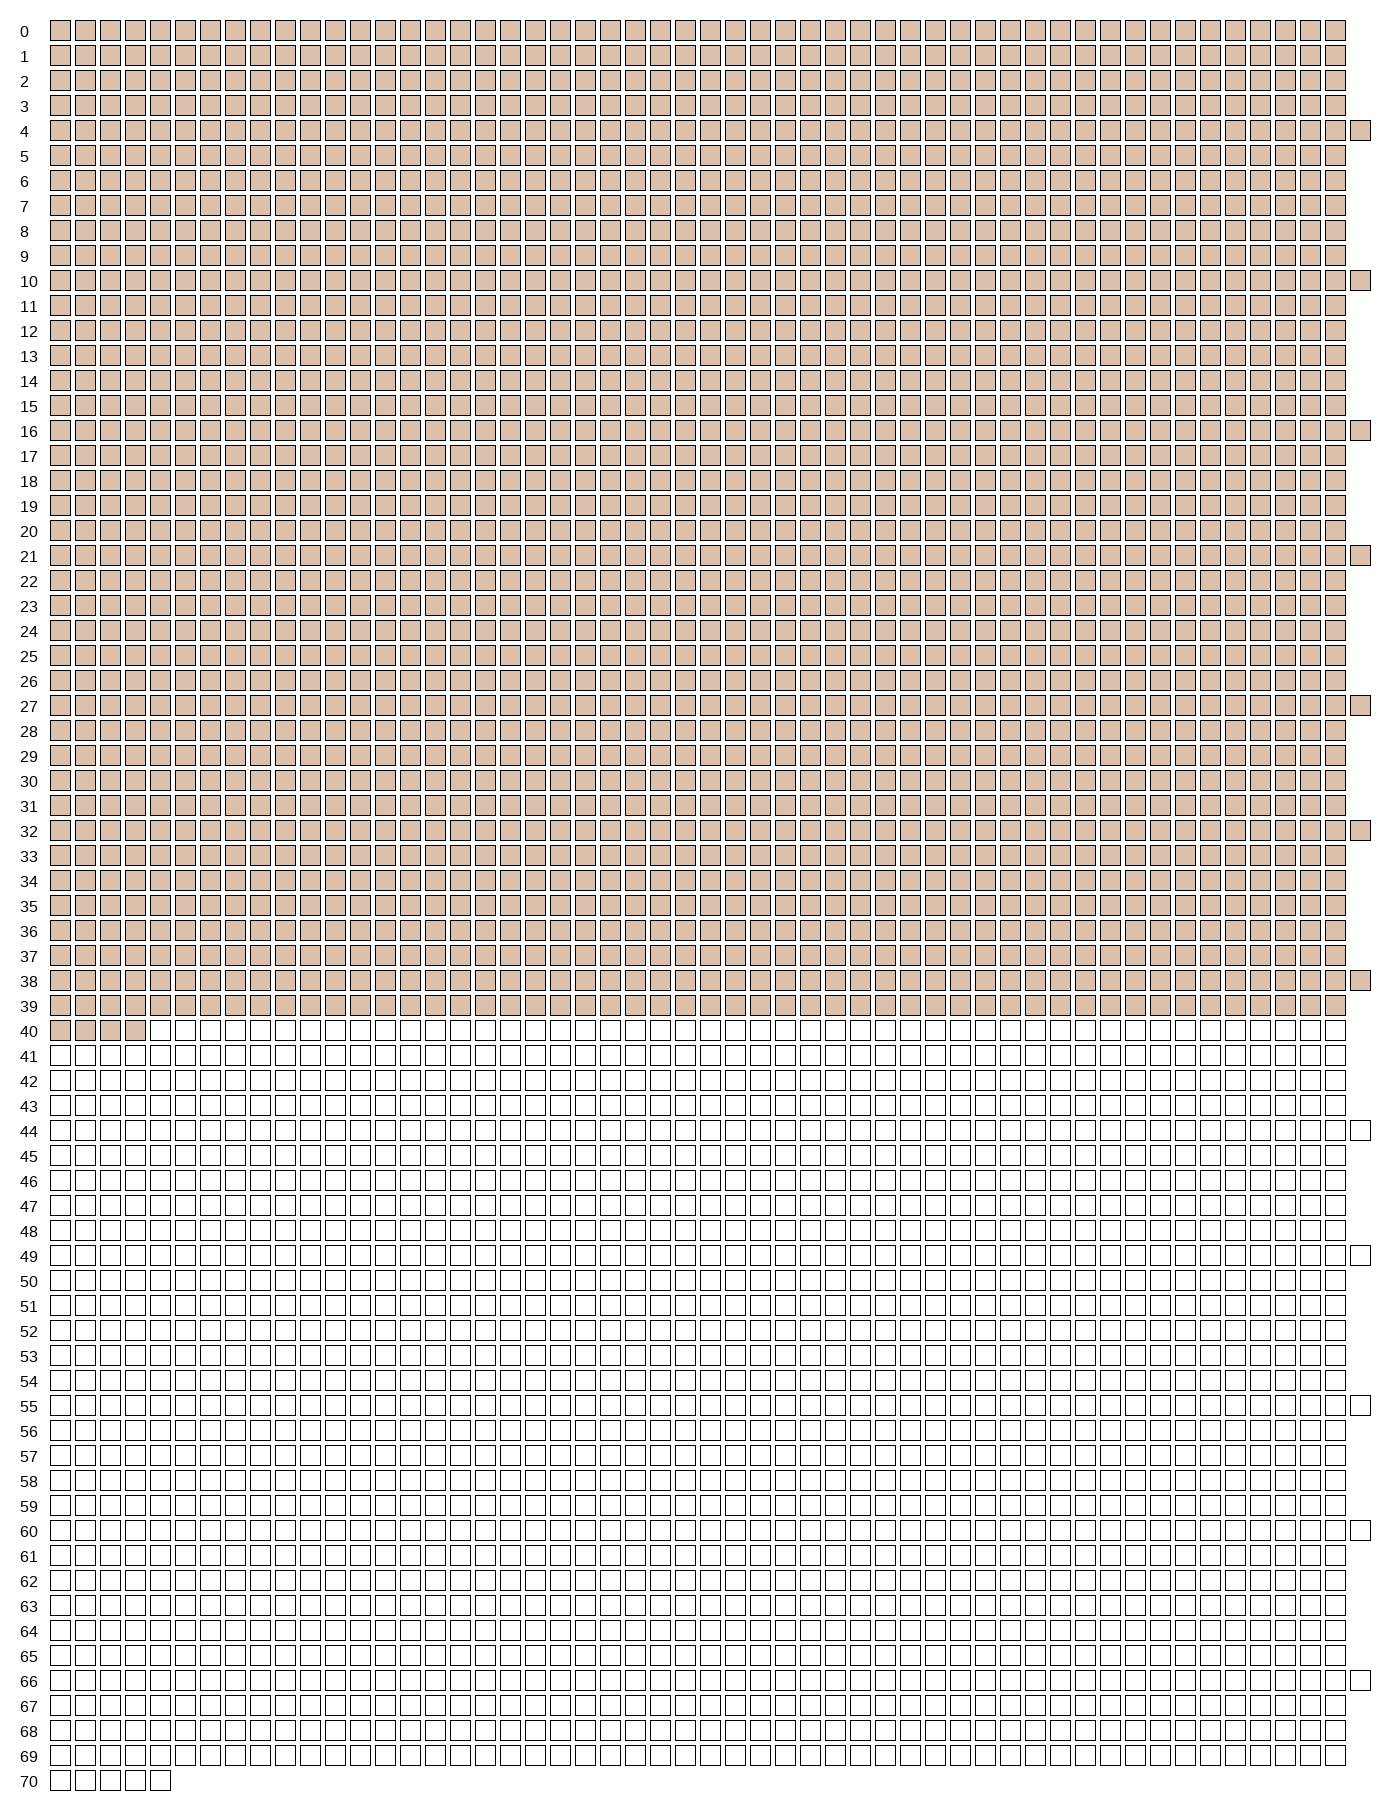

In [13]:
# @title Квадратики неделей жизни { display-mode: "form" }
import math
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def draw_week_squares_pillow(weeks_passed, weeks_left, gap=5, margin=20):
    total_weeks = weeks_passed + weeks_left
    years = math.ceil(total_weeks * 7 / 365.25)
    weeks_per_year = 52
    square_size = 20
    text_margin = 30  # Дополнительное пространство для текста
    image_width = (weeks_per_year + 1) * (square_size + gap) - gap + 2 * margin + text_margin
    image_height = years * (square_size + gap) - gap + 2 * margin

    # Создаем новое изображение
    image = Image.new("RGB", (image_width, image_height), "white")
    draw = ImageDraw.Draw(image)

    # Настраиваем шрифт
    font_path = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"  # Путь к шрифту LiberationSans
    try:
        font = ImageFont.truetype(font_path, 16)
    except IOError:
        font = ImageFont.load_default()

    year = -1
    new_line = True
    extra_days = 0  # непосчитанные дни: 1 день в году не попадает в неделю + 1 день в високосный
    next_year_week = 0

    for week in range(total_weeks):
        if week == next_year_week:
            year += 1
            week_in_year = 0
            year_number = str(year)
            text_x = margin
            text_y = margin + year * (square_size + gap) + (square_size / 2) - 8
            draw.text((text_x, text_y), year_number, fill="black", font=font)
            next_year_week += 52
            extra_days += 1 + (year % 4 == 0)
            if extra_days >= 7:
                next_year_week += 1
                extra_days -= 7

        if week < weeks_passed:
            fill_color = "#dbc1ac"  # Закрашенные (пройденные) недели
        else:
            fill_color = "white"  # Незакрашенные (оставшиеся) недели

        x = text_margin + margin + week_in_year * (square_size + gap)
        y = margin + year * (square_size + gap)
        draw.rectangle([x, y, x + square_size, y + square_size], outline="black", fill=fill_color)
        week_in_year += 1


    display(image)

# Пример использования: 30 недель пройденных и 22 недели оставшихся
draw_week_squares_pillow(weeks_passed, weeks_left, gap=5, margin=20)


## Кто я?

Каким сферам я хочу уделять время? Какое мое многоборье? Создай проект под каждую свою деятельность, включая отдых. Например:
- Предприниматель
- Музыкант
- Семьянин
- Друг
- Путшественник
- Иноагент
- Колдун
- Отдых

In [2]:
# @title { run: "auto", display-mode: "form" }
# @markdown Запускай эту клетку всегда, даже когда загружаешь сохраненное состояние
from typing_extensions import Literal
from typing import Annotated, Optional, Union

import ipywidgets as widgets
from IPython.display import display
from pydantic import BaseModel, Field

choosen_color = None
projects = []


CONSTANT = "Константная"
SQUARE = "Квадратная"
SINUSOID = "Синусоида"


class FormParameters_Constant(BaseModel):
    form: Literal[CONSTANT]
    hours_max: float

    def time_function(self, x):
        return np.full_like(x, self.hours_max)

class FormParameters_Square(BaseModel):
    form: Literal[SQUARE]
    hours_min: float
    hours_max: float
    is_stochastic: bool
    period: int
    active_period: int
    offset: int

    def time_function(self, x):
        if self.is_stochastic:
            day = self.offset
            y = np.full_like(x, self.hours_min)
            while day < len(x):
                next_active_period = day + int(np.round(np.random.exponential(scale=self.period)))
                active_period_length = int(np.round(np.random.exponential(scale=self.active_period)))
                if next_active_period >= len(x):
                    break
                y[next_active_period:next_active_period + active_period_length] = self.hours_max
                day = next_active_period + active_period_length
        else:
            square_mask = ((np.arange(len(x)) - self.offset) % self.period) < self.active_period
            y = np.where(square_mask, self.hours_max, self.hours_min)
        return y


class FormParameters_Sinusoid(BaseModel):
    form: Literal[SINUSOID]
    hours_min: float
    hours_max: float
    period: int
    offset: int

    def time_function(self, x):
        x = x - self.offset
        # Генерация значений синусоиды от -1 до 1
        y_raw = np.sin(2 * np.pi * x / self.period)
        # Масштабирование значений синусоиды от sin_min до sin_max
        y = (y_raw + 1) / 2 * (self.hours_max - self.hours_min) + self.hours_min
        return y


FormParameters = Annotated[
    Union[
        FormParameters_Constant,
        FormParameters_Square,
        FormParameters_Sinusoid
    ],
    Field(discriminator="form")
]


class Project(BaseModel):
    name: str = Field(..., description="Название проекта", min_length=1)
    color: str
    form_function: FormParameters

print(
    "Укажите сколько в день активных часов = 24 - время на сон - время на еду"
    " - другое время, которое нельзя потратить на проекты"
)

active_hours_widget = widgets.FloatSlider(value=16, min=0.25, max=24, step=0.25)
active_hours_widget

Укажите сколько в день активных часов = 24 - время на сон - время на еду - другое время, которое нельзя потратить на проекты


FloatSlider(value=16.0, max=24.0, min=0.25, step=0.25)

In [15]:
# @title { run: "auto", display-mode: "form" }
import random
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Layout

# default styling
class StyledWidgets:
    def __init__(self, style, layout):
        self.style = style
        self.layout = layout

    def __getattr__(self, name):
        original_attr = getattr(widgets, name)
        if callable(original_attr) and name[0] == name[0].upper():
            def wrapper(*args, **kwargs):
                if "layout" not in kwargs:
                    kwargs["layout"] = self.copy_layout(self.layout)
                res = original_attr(*args, **kwargs)
                if "description" in kwargs:
                    for key, value in self.style.items():
                        setattr(res.style, key, value)
                return res
            return wrapper
        else:
            return original_attr

    @staticmethod
    def copy_layout(layout):
        if not isinstance(layout, widgets.Layout):
            raise TypeError("Input must be an instance of ipywidgets.Layout")
        layout_attrs = {
            attr: getattr(layout, attr)
            for attr in layout.keys
            if getattr(layout, attr) is not None
            and not attr.startswith("_")
        }

        new_layout = widgets.Layout(**layout_attrs)
        return new_layout


styled_widgets = StyledWidgets(
    {"description_width": "initial"},
    Layout(width="500px", height="50px")
)


print("Задайте имя проекта, выберите для него цвет и настройте функции его времени")

# Имя проекта
project_name_widget = styled_widgets.Text(
    value='Писатель',
    placeholder='Кто я?',
    description='Имя проекта:',
    disabled=False
)

# Инструкция
instruction_html = styled_widgets.HTML(
    value="""
    <p>Создайте функцию времени. Для этого выберите ее форму и период.</p>
    <p>
      Доступные формы:
      <ul>
        <li> <b>константная</b>: когда каждый день выделено одинаковое время </li>
        <li> <b>квадратная</b>: когда временами делается фиксированный фокус на проект </li>
        <li> <b>синусоида</b>: когда время на сферу меняется плавно </li>
      </ul>
    </p>
    <p>
      Параметры:
      <ul>
        <li>
          <b>Диапазон часов</b>: задай диапазон от <i>часов на минимуме</i>
          до <i>часов на пике</i>, где:
          <ul>
            <li> <b>часов на пике</b>: высота функции - сколько часов в день
            выделено в точке, когда функция достигает максимума </li>
            <li> <b>часов на минимуме</b>: нижняя точка функции - сколько часов в
            день выделено на минимуме (минимальное полезное действие в день) </li>
          </ul>
        </li>
        <li> <b>период</b>: период полного цикла проекта в днях </li>
        <li> <b>активный период</b>: для квадратной функции сколько дней из
        всего периода отведено под проект (оставшиеся дни делается минимальное
        полезное действие, если нужно) </li>
        <li> <b>сдвиг</b>: число дней до начала цикла
        <li> <b>случайные периоды активности</b>: лля квадратной функции
        отметь галочку, если длина периода и активного периода случайна.
        В этом случае значения полей "период" и "активный период" будут задавать
        не точное, а среднее число дней. Случайное распределение - экспоненциальное
     </ul>
    """,
)
instruction_html.layout.width = "600px"
instruction_html.layout.height = "initial"

# Цвет проекта
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))


color_picker = styled_widgets.ColorPicker(
    description="Выберите цвет:",
    value=random_color() if choosen_color is None else choosen_color,
    disabled=False
)

def on_color_change(change):
    global choosen_color
    choosen_color = change["new"]
    project_name = project_name_widget.value

color_picker.observe(on_color_change, names="value")

# Выбор формы
form_selector = styled_widgets.Dropdown(
    options=[
        CONSTANT,
        SQUARE,
        SINUSOID
    ],
    value=CONSTANT,
    description="Форма функции времени:",
)

# Диапазон часов
hours_slider = styled_widgets.FloatRangeSlider(
    value=(0, 8),
    min=0,
    max=active_hours_widget.value,
    step=0.25,
    description="Диапазон часов:",
)

# Периоды активности
stochastic_checkbox = styled_widgets.Checkbox(
    value=False,
    description="Случайные периоды активности",
    disabled=False
)

regenerate_button = styled_widgets.Button(
    description="Пересгенерировать",
    disabled=False,
)
# Создаем невидимый виджет
update_trigger = widgets.Label()

def redraw_plot(button):
    # Меняем значение невидимого виджета, чтобы вызвать обновление
    update_trigger.value = str(np.random.random())

regenerate_button.on_click(redraw_plot)


period_widget = styled_widgets.IntText(
    value=7,
    min=1,
    step=1,
    description="Период в днях"
)

active_period_widget = styled_widgets.IntText(
    value=5,
    min=1,
    step=1,
    description="Активный период в днях"
)

offset_widget = styled_widgets.IntText(
    value=0,
    min=0,
    step=1,
    description="Сдвиг периода в днях"
)

stochastic_checkbox.layout.display = "none"
period_widget.layout.display = "none"
active_period_widget.layout.display = "none"
regenerate_button.layout.display = "none"
offset_widget.layout.display = "none"

# Функция обратного вызова для изменения видимости текстового поля
def on_form_change(change):
    if change["new"] == CONSTANT:
        stochastic_checkbox.layout.display = "none"
        regenerate_button.layout.display = "none"
        period_widget.layout.display = "none"
        active_period_widget.layout.display = "none"
        offset_widget.layout.display = "none"
    elif change["new"] == SQUARE:
        stochastic_checkbox.layout.display = "block"
        if stochastic_checkbox.value:
            regenerate_button.layout.display = "block"
        else:
            regenerate_button.layout.display = "none"
        period_widget.layout.display = "block"
        active_period_widget.layout.display = "block"
        offset_widget.layout.display = "block"
    elif change["new"] == SINUSOID:
        stochastic_checkbox.layout.display = "none"
        regenerate_button.layout.display = "none"
        period_widget.layout.display = "block"
        active_period_widget.layout.display = "none"
        offset_widget.layout.display = "block"


form_selector.observe(on_form_change, names="value")


# Функция обратного вызова на чекбокс случайности
def on_stochastic_change(change):
    if change["new"]:
        period_widget.description = "Средний период в днях"
        active_period_widget.description = "Средний активный период в днях"
        regenerate_button.layout.display = "block"
    else:
        period_widget.description = "Период в днях"
        active_period_widget.description = "Активный период в днях"
        regenerate_button.layout.display = "none"


stochastic_checkbox.observe(on_stochastic_change, names="value")


def plot_time_function(
    color,
    form,
    hours_range,
    is_stochastic,
    update_trigger,
    period,
    active_period,
    offset
):
    hours_min, hours_max = hours_range
    if period <= 7:
        last_day = 14
    elif period <= 15:
        last_day = 30
    elif period <= 31:
        last_day = 61
    elif period <= 365:
        last_day = 365
    else:
        last_day = period + 30

    x = np.arange(last_day)
    project = Project(
        name="Demo project",
        color=color,
        form_function=dict(
            form=form,
            hours_min=hours_min,
            hours_max=hours_max,
            is_stochastic=is_stochastic,
            period=period,
            active_period=active_period,
            offset=offset
        )
    )
    y = project.form_function.time_function(x)

    plt.figure(figsize=(10, 5))
    # plt.plot(x, y, color=color)
    plt.fill_between(x, y, color=color)
    plt.ylim(0, 24)
    plt.xlabel("Дни")
    plt.ylabel("Количество часов")
    plt.title("Количество часов на проект по дням")
    plt.grid(True)
    plt.show()


interactive_plot = widgets.interactive_output(
    plot_time_function,
    dict(
        color=color_picker,
        form=form_selector,
        hours_range=hours_slider,
        is_stochastic=stochastic_checkbox,
        update_trigger=update_trigger,
        period=period_widget,
        active_period=active_period_widget,
        offset=offset_widget
    )
)

submit_button = styled_widgets.Button(
    description="Добавить проект",
    disabled=False,
    button_style="success"
)

def add_project(button):
    project = Project(
        name=project_name_widget.value,
        color=color_picker.value,
        form_function=dict(
            form=form_selector.value,
            hours_min=hours_slider.value[0],
            hours_max=hours_slider.value[1],
            is_stochastic=stochastic_checkbox.value,
            period=period_widget.value,
            active_period=active_period_widget.value,
            offset=offset_widget.value
        )
    )
    projects.append(project)
    print(f'Проект "{project.name}" добавлен')
    # Сброс формы
    project_name_widget.value = ""
    color_picker.value = random_color()
    form_selector.value = CONSTANT
    hours_slider.value = (0, 8)
    stochastic_checkbox.value = False
    period_widget.value = 7
    active_period_widget.value = 5
    offset_widget.value = 0

submit_button.on_click(add_project)

# Настройка Layout
item_layout = widgets.Layout(flex='1 1 auto', width='auto')
container_layout = widgets.Layout(display='flex', flex_flow='row wrap', align_items='stretch')

# Объединение виджетов в контейнеры
ui_container = widgets.VBox([
    project_name_widget,
    instruction_html,
    color_picker,
    form_selector,
    hours_slider,
    stochastic_checkbox,
    regenerate_button,
    period_widget,
    active_period_widget,
    offset_widget,
    submit_button
], layout=item_layout)

plot_container = widgets.VBox([interactive_plot], layout=item_layout)

# Основной контейнер
main_container = widgets.HBox([ui_container, plot_container], layout=container_layout)

# Отображение
display(main_container)

Задайте имя проекта, выберите для него цвет и настройте функции его времени


Проект "Предприниматель" добавлен
Проект "Музыкант" добавлен
Проект "Семьянин" добавлен
Проект "Друг" добавлен
Проект "Путешественник" добавлен
Проект "Иноагент" добавлен
Проект "Колдун" добавлен
Проект "Отдых" добавлен


In [16]:
projects

[Project(name='Предприниматель', color='#f66151', form_function=FormParameters_Sinusoid(form='Синусоида', hours_min=0.0, hours_max=12.0, period=183, offset=-30)),
 Project(name='Музыкант', color='#c061cb', form_function=FormParameters_Square(form='Квадратная', hours_min=0.0, hours_max=2.0, is_stochastic=False, period=30, active_period=2, offset=10)),
 Project(name='Семьянин', color='#69fc8b', form_function=FormParameters_Constant(form='Константная', hours_max=1.5)),
 Project(name='Друг', color='#9b6f4f', form_function=FormParameters_Square(form='Квадратная', hours_min=0.0, hours_max=6.0, is_stochastic=True, period=21, active_period=1, offset=0)),
 Project(name='Путешественник', color='#ffa348', form_function=FormParameters_Square(form='Квадратная', hours_min=0.0, hours_max=12.0, is_stochastic=True, period=365, active_period=30, offset=0)),
 Project(name='Иноагент', color='#241f31', form_function=FormParameters_Square(form='Квадратная', hours_min=0.5, hours_max=8.0, is_stochastic=False,

In [20]:
# @title { run: "auto", display-mode: "form" }
import pandas as pd
try:
    weeks_left
except NameError:
    weeks_left = 52 * 50

days_left = weeks_left * 7
active_hours = active_hours_widget.value

# Сгенерируем желаемые затраты времени в день
x = np.arange(days_left)
project_functions = []
for project in projects:
    y = project.form_function.time_function(x)
    project_functions.append(y)

project_functions = np.vstack(project_functions)

# Так как день ограничен active_hours, то там где
# - желаемых часов < active_hours, заполним псевдопроектом "свободные часы"
# - желаемых часов > active_hours, выберем проект, который будет приоритетнее
#   случайно, пропорционально его общему количеству часов
# В итоге сумма в каждом столбце должна стать равна active_hours

time_deficit = np.sum(project_functions, axis=0) - active_hours

need_choice = time_deficit > 0


def generate_permutations(probabilities):
    positive = probabilities > 0
    n_choices = probabilities[positive].shape[0]
    return np.concatenate(
        (
            np.random.choice(
                len(probabilities),
                size=n_choices,
                replace=False,
                p=probabilities
            ),
            np.where(~positive)[0]
        )
    )


def random_priority_permutations(matrix):
    # Нормализуем матрицу, чтобы суммы по столбцам были равны 1 (вероятности)
    probabilities = matrix / np.sum(matrix, axis=0)

    # Применяем функцию генерации перестановок к каждому столбцу матрицы
    result = np.apply_along_axis(generate_permutations, 0, probabilities)

    return result


def wheel_of_fortuna(overloaded):
    deficit = np.sum(overloaded, axis=0) - active_hours
    deficit[deficit < 0] = 0
    priority = random_priority_permutations(overloaded)

    for lowest_prior in reversed(range(priority.shape[0])):
        row_indices = priority[lowest_prior]
        col_indices = np.arange(overloaded.shape[1])
        overloaded[row_indices, col_indices] -= deficit
        antideficit = overloaded[row_indices, col_indices]
        # где стало меньше 0, там еще нужно убрать
        # где стало больше или равно 0, там дефицита не осталось
        deficit = np.where(antideficit >= 0, 0, -antideficit)
    overloaded[overloaded < 0] = 0
    return overloaded

def normalize_hours(overloaded):
    return overloaded / np.sum(overloaded, axis=0) * active_hours

if need_choice.any():
    project_functions[:, need_choice] = wheel_of_fortuna(
        project_functions[:, need_choice]
    )

spare_time = np.full(days_left, active_hours) - np.sum(project_functions, axis=0)
spare_time[spare_time < 0] = 0

# add row spare time to project_functions
project_functions = np.vstack((project_functions, spare_time))

# Fix start date
start_date = pd.to_datetime(datetime.now())

# Show statistics
total_hours = active_hours * days_left
print(f"Итого из {total_hours} часов:")
for project, hours in zip(projects, np.sum(project_functions[:-1], axis=1)):
    part = hours / total_hours * 100
    print(f"- {project.name}: {hours:.2f} часов ({part:.2f}%)")
free_hours = np.sum(project_functions[-1])
free_part = free_hours / total_hours * 100
print(f"- Свободное время: {free_hours:.2f} часов ({free_part:.2f}%)")

Итого из 131544.0 часов:
- Предприниматель: 55299.86 часов (42.04%)
- Музыкант: 964.87 часов (0.73%)
- Семьянин: 6730.12 часов (5.12%)
- Друг: 1965.49 часов (1.49%)
- Путешественник: 10476.48 часов (7.96%)
- Иноагент: 15649.19 часов (11.90%)
- Колдун: 4027.83 часов (3.06%)
- Отдых: 8658.13 часов (6.58%)
- Свободное время: 27772.03 часов (21.11%)


In [1]:
# SAVE / LOAD
# @title { run: "auto", display-mode: "form" }
import pickle

import ipywidgets as widgets
from google.colab import files
from IPython.display import display, clear_output

# Define a function to save the variables to a file
def save_variables(filename):
  with open(filename, 'wb') as f:
    pickle.dump([projects, active_hours, weeks_left, project_functions, start_date], f)

# Define a function to load the variables from a file
def load_variables(filename):
  global projects, active_hours, weeks_left, project_functions, start_date
  with open(filename, 'rb') as f:
    projects, active_hours, weeks_left, project_functions, start_date = pickle.load(f)


# Create buttons
save_button = widgets.Button(description='Сохранить')
load_button = widgets.Button(description='Загрузить')

# Define button actions
def on_save_button_clicked(b):
  show_buttons()  # reset output
  save_variables('alternate.pickle')
  files.download('alternate.pickle')

def on_load_button_clicked(b):
  show_buttons()  # reset output
  try:
    Project
  except NameError:
    raise ImportError(
        "Перед загрузкой необходимо выполнить первую клетку раздела 'Кто я?',"
        "где настраиваешь активное количество часов. "
        "Количество активных часов можно не выставлять - оно возьмется из сохранения."
    )
  uploaded = files.upload()
  if uploaded:
    filename = next(iter(uploaded))
    load_variables(filename)

save_button.on_click(on_save_button_clicked)
load_button.on_click(on_load_button_clicked)

# Display buttons
def show_buttons():
    clear_output()
    display(widgets.HBox([save_button, load_button]))

show_buttons()

Saving alternate.pickle to alternate (4).pickle


In [3]:
# @title { run: "auto", display-mode: "form" }
from datetime import datetime

import plotly.graph_objects as go
import pandas as pd
import numpy as np


# Создание DataFrame для работы с Plotly
df = pd.DataFrame(
    project_functions.T,
    columns=[project.name for project in projects] + ["Свободное время"]
)

color_map = {project.name: project.color for project in projects}
color_map["Свободное время"] = "#dddddd"

df['date'] = pd.date_range(start=start_date, periods=df.shape[0], freq='D')

# Создание графика с областями
fig = go.Figure()

# Добавляем каждый проект на график
for i, project in enumerate(df.columns[:-1]):
    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df[project],
        mode='lines',
        name=project,
        hovertemplate='%{y:.2f} ч.',
        line=dict(color=color_map[project]),
        stackgroup='one'  # Объединяем в одну группу
    ))

# Настройки осей и отображения
fig.update_layout(
    title="Распределение времени между проектами по дням",
    xaxis_title='Дата',
    yaxis_title='Число часов',
    hovermode='x unified',  # Объединяем подсказки для одной точки по оси X
    hoverlabel=dict(
        bgcolor="rgba(255, 255, 255, 0.7)",  # Полупрозрачный фон
        font_size=12
    )
)

# Показать график
fig.show()


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

